In [1]:
# 查看给定计算场景和性能参数下，实际和估计在不同k取值时的时延期望

import sys
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random

# from coded_distributed_inference.coded_convolution import MDS_conv_optimal_k

# new version: 2024/01/02
# computation scenario
B = 1

# The second layer of VGG16
# input shape
C_i, H_i, W_i = 64, 224, 224
# output shape
C_o, H_o, W_o = 64, 224, 224
# conv
kernel_size, stride = 3, 1

# # The first layer of VGG16
# # input shape
# C_i, H_i, W_i = 64, 112, 112
# # output shape
# C_o, H_o, W_o = 192, 64, 64
# # conv
# kernel_size, stride = 7, 2


# C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride = (128, 112, 112, 128, 112, 112, 3, 1)

# MDS code
k = 3
n = 20
scale = 300000  # shape (scale, n) for generating random variables, n values per group

# rate parameter and shift parameter, should be set with proper values: 这个参数范围好像估计不准。。？
#  master
# mu_cmp, theta_cmp = 1256795898.461681, 1.07302376834754e-9
# mu_recv, theta_recv = (664462.534600538, 7.830451648901523e-07)
# mu_send, theta_send = (1196715.6576084406, 3.3184532218673076e-07)

mu_cmp, theta_cmp = 1e7, 1e-7
# mu_recv, theta_recv = (1e8, 1e-8)
# mu_send, theta_send = (1e8, 1e-8)
mu_recv_0, theta_recv_0 = (1e8, 1e-8)
mu_send_0, theta_send_0 = (1e8, 1e-8)

mu_m, theta_m = mu_cmp, theta_cmp


# #  worker: 4 CPU cores, 1.5 GHz = 1.5 * 10^9 Hz, maximum 10 MB/s
# #  - mu for computation: floating point operation per second
# #  - theta for computation: seconds per floating point operation
# #  - mu for transmission: bytes per second (B/s)
# #  - theta for computation: seconds per byte (s/B)
# mu_tr = mu_rec = mu_sen = 1e6
# theta_tr = theta_rec = theta_sen = 1e-7
# mu_cmp, theta_cmp = 1e8, 1e-8

def estimated_latency(C_i, H_i, C_o, H_o, W_o, kernel_size, stride,
                      mu_cmp, theta_cmp, mu_rec, theta_rec, mu_sen, theta_sen, n, k):
    result = (2*k*n*C_i*H_i*(kernel_size+(W_o/k-1)*stride) + 2*k*C_o*H_o*W_o)*(1/mu_cmp+theta_cmp) \
        +4*C_i*H_i*(kernel_size+(W_o/k-1)*stride)*theta_rec + 4*C_o*H_o*W_o/k*theta_sen + C_o*H_o*W_o/k*2*C_i*(kernel_size**2)*theta_cmp \
        +(4*C_i*H_i*(kernel_size+(W_o/k-1)*stride)/mu_rec + 4*C_o*H_o*W_o/(k*mu_sen) + C_o*H_o*W_o*2*C_i*(kernel_size**2)/(k*mu_cmp))*np.log(n/(n-k))/np.log(np.pi)
    return result

save_fig = False

Es_kth_Ts_w_n = []
approx_n = []

for n in range(3, 30):  # 改成了遍历所有的n的画图
    print('n =',n)

    # transformation of mu_tr, theta_tr and n
    mu_recv = mu_recv_0 / n
    theta_recv = theta_recv_0 * n
    mu_send = mu_send_0 / n
    theta_send = theta_send_0 * n

    W_p_o = W_o / k
    W_p_i = kernel_size + (W_p_o - 1) * stride

    N_cmp = C_o * H_o * W_p_o * (2 * C_i * kernel_size * kernel_size - 1)
    N_rec = np.prod([4, C_i, H_i, W_p_i])
    N_sen = np.prod([4, C_o, H_o, W_p_o])
    N_tr_sum = N_rec + N_sen
    print(N_cmp / N_tr_sum)
    # sys.exit(0)


    a = 2 * (1 / mu_m + theta_m) * (n * C_i * H_i * (kernel_size - stride) + C_o * H_o * W_o)
    # b = 4 * W_o * theta_tr * (C_i * H_i * stride + C_o * H_o) \
    #     + np.prod([2, C_o, H_o, W_o, C_i, kernel_size, kernel_size, theta_cmp]) \
    #     - n * C_i * H_i * W_i / mu_m
    b = 4 * W_o * (C_i * H_i * stride * theta_recv + C_o * H_o * theta_send) + np.prod(
        [2, C_o, H_o, W_o, C_i, kernel_size ** 2, theta_cmp])
    # 谁能告诉我下面这俩有什么区别啊啊啊啊啊啊啊啊
    # c = 4 * W_o * (C_i * H_i * stride / mu_recv + C_o * H_o / mu_send) + np.prod(  # wrong
    #     [2, C_o, H_o, W_o, C_i, kernel_size ** 2]) / mu_cmp
    c = 4 * W_o * (C_i * H_i * stride / mu_recv + C_o * H_o / mu_send) + np.prod(
        [2, C_o, H_o, W_o, C_i, kernel_size ** 2, 1 / mu_cmp])
    d = 4 * C_i * H_i * (kernel_size - stride) / mu_recv
    # b = 4 * W_o * theta_tr * (C_i * H_i * stride + C_o * H_o) \
    #     + np.prod([2, C_o, H_o, W_o, C_i, kernel_size, kernel_size, theta_cmp]) \
    #     - n * C_i * H_i * W_o * stride / mu_m
    # c = W_o * (4 * (C_i * H_i * stride + C_o * H_o) / mu_tr + np.prod([2, C_o, H_o, C_i, kernel_size ** 2]) / mu_cmp)
    
    # print(f'a:{a}')
    # print(f'b:{b}')
    # print(f'c:{c}')
    # print(f'd:{d}')

    # mu_rec = mu_sen = 1e8
    # theta_rec = theta_sen = 1e-7
    # mu_cmp, theta_cmp = 1e5, 1e-8


    # 少了一部分不含k的值，所以绝对值肯定不一样，但是注意变化趋势
    term_without_k = 2*n*C_i*H_i*W_o*stride*(1/mu_m+theta_m) + 4*C_i*H_i*(kernel_size-stride)*theta_recv
    # approx = [a * k + b / k + c / k * np.log(n / (n - k)) + d * np.log(n / (n - k)) for k in range(2, n)]
    approx = [estimated_latency(C_i, H_i, C_o, H_o, W_o, kernel_size, stride,
                          mu_cmp, theta_cmp, mu_recv, theta_recv, mu_send, theta_send, n, k) for k in range(2, n)]


    approx_1 = [a * k + b / k + c / k * np.log(n / (n - k)) + d * np.log(n / (n-k)) + term_without_k for k in range(2, n)]
    # approx_2 = [b / k + c / k * np.log(n / (n - k)) for k in range(2, n)]

    Es_kth_Ts_w = []
    Es_sum_kth = []

    for k in tqdm(range(2, n)):
        W_p_o = W_o / k
        # W_p_o = W_o / k  # approximation
        W_p_i = kernel_size + (W_p_o - 1) * stride

        N_enc = np.prod([(2 * k - 1), n, B, C_i, H_i, W_p_i])  # in FLOPs (floating point operations)
        N_dec = np.prod([(2 * k - 1), k, B, C_o, H_o, W_p_o])  # in FLOPs
        N_conv = np.prod([2, B, C_o, H_o, W_p_o, C_i, kernel_size ** 2])  # in FLOPs
        N_in = np.prod([B, C_i, H_i, W_p_i, 4])  # in bytes
        N_out = np.prod([B, C_o, H_o, W_p_o, 4])  # in bytes

        # print(N_enc, N_dec, N_in, N_out, N_conv)

        # print(f'k:{k}, N_enc and N_dec: {N_enc+N_dec}, N_in: {N_in}, N_conv: {N_conv}, N_out: {N_out}')

        # latency of encoding and decoding on master
        # T_enc = 2 / mu_m + N_enc * theta_m
        # T_dec = 2 / mu_m + N_dec * theta_m
        T_enc = N_enc * (1 / mu_cmp + theta_cmp)
        T_dec = N_dec * (1 / mu_cmp + theta_cmp)
        T_m = T_enc + T_dec
        # print(f'Encoding and decoding on master: {T_m}')

        # update mu in exponential distribution for latency modeling
        _mu_rec = N_in / mu_recv
        _mu_cmp = N_conv / mu_cmp
        _mu_sen = N_out / mu_send

        # _mu_rec = mu_rec / N_in
        # _mu_cmp = mu_cmp / N_conv
        # _mu_sen = mu_sen / N_out

        # generate random variables following exponential distribution to estimate kth order statistic
        Ts_rec = random.exponential(_mu_rec, (scale, n))
        Ts_cmp = random.exponential(_mu_cmp, (scale, n))
        Ts_sen = random.exponential(_mu_sen, (scale, n))

        Ts_w = Ts_rec + Ts_cmp + Ts_sen
        sum_offset = N_in * theta_recv + N_conv * theta_cmp + N_out * theta_send

        # kth order statistic of Ts_w, Ts_rec, Ts_cmp, Ts_sen
        kth_Ts_w = np.partition(Ts_w, k - 1, axis=1)[:, k - 1]
        E_kth_Ts_w = np.mean(kth_Ts_w) + sum_offset + T_m
        Es_kth_Ts_w.append(E_kth_Ts_w)

        kth_Ts_rec = np.partition(Ts_rec, k - 1, axis=1)[:, k - 1]
        kth_Ts_cmp = np.partition(Ts_cmp, k - 1, axis=1)[:, k - 1]
        kth_Ts_sen = np.partition(Ts_sen, k - 1, axis=1)[:, k - 1]

        # estimation with
        sum_kth_Ts = kth_Ts_rec + kth_Ts_cmp + kth_Ts_sen
        E_sum_kth = np.mean(sum_kth_Ts) + sum_offset + T_m
        Es_sum_kth.append(E_sum_kth)

    # ks = np.asarray(list(range(2, n)))
    ks = np.arange(2, n).astype(str)
    k_num = []

    Es_kth_Ts_w_n.append(Es_kth_Ts_w)
    approx_n.append(approx)

    # plt.figure(figsize=(5,5))
    # plt.grid(zorder=-1)
    # plt.plot(ks, Es_kth_Ts_w, 'o--', linewidth=1, label='Actual', markerfacecolor='white', markersize=8)
    # # plt.plot(ks, Es_sum_kth, 'r*--', alpha=0.5, linewidth=1, label='Estimated')
    # plt.plot(ks, approx, 'x--', linewidth=1, label='Approx', markersize=10)
    # # plt.plot(ks, approx_1, 'y*--', alpha=0.5, linewidth=1, label='Approx^2')

    # plt.xticks(list(range(0, 20, 3)), size=20)
    # plt.yticks(size=15)

    # # diff_rates_estimated = []
    # diff_rates_approx = []
    # for actua, appro in zip(Es_kth_Ts_w, approx):
    #     diff_rate = abs(actua - appro) / actua
    #     diff_rates_approx.append(diff_rate)
    # print('Max Diff rate:', max(diff_rates_approx))
    # plt.rcParams.update({'font.size': 15})
    # plt.legend()
    # plt.title(f'n={n}')
    # plt.xlabel('$k$', size=20)
    # plt.ylabel('$E[T^c]$', size=20)
    # plt.tight_layout()
    # if save_fig:
    #     plt.savefig('E_latency_actual_approx_k.pdf')
    # # draw the distribution with instances: what does x-axis means?

    # plt.show()


n = 3
141.97356828193833


100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


n = 4
142.60176991150442


100%|██████████| 2/2 [00:00<00:00, 13.70it/s]


n = 5
141.97356828193833


100%|██████████| 3/3 [00:00<00:00, 11.36it/s]


n = 6
141.35087719298247


100%|██████████| 4/4 [00:00<00:00,  9.26it/s]


n = 7
140.73362445414847


100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


n = 8
140.12173913043478


100%|██████████| 6/6 [00:00<00:00,  6.55it/s]


n = 9
139.5151515151515


100%|██████████| 7/7 [00:01<00:00,  5.75it/s]


n = 10
138.91379310344828


100%|██████████| 8/8 [00:01<00:00,  4.89it/s]


n = 11
138.3175965665236


100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


n = 12
137.72649572649573


100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


n = 13
137.1404255319149


100%|██████████| 11/11 [00:02<00:00,  3.76it/s]


n = 14
136.5593220338983


100%|██████████| 12/12 [00:03<00:00,  3.49it/s]


n = 15
135.9831223628692


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


n = 16
135.41176470588235


100%|██████████| 14/14 [00:04<00:00,  3.03it/s]


n = 17
134.84518828451883


100%|██████████| 15/15 [00:05<00:00,  2.84it/s]


n = 18
134.28333333333333


100%|██████████| 16/16 [00:05<00:00,  2.70it/s]


n = 19
133.72614107883817


100%|██████████| 17/17 [00:06<00:00,  2.58it/s]


n = 20
133.17355371900825


100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


n = 21
132.6255144032922


100%|██████████| 19/19 [00:08<00:00,  2.14it/s]


n = 22
132.08196721311475


100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


n = 23
131.54285714285714


100%|██████████| 21/21 [00:14<00:00,  1.46it/s]


n = 24
131.0081300813008


100%|██████████| 22/22 [00:15<00:00,  1.40it/s]


n = 25
130.47773279352228


100%|██████████| 23/23 [00:17<00:00,  1.35it/s]


n = 26
129.9516129032258


100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


n = 27
129.429718875502


100%|██████████| 25/25 [00:19<00:00,  1.25it/s]


n = 28
128.912


100%|██████████| 26/26 [00:21<00:00,  1.22it/s]


n = 29
128.39840637450197


100%|██████████| 27/27 [00:23<00:00,  1.17it/s]


In [2]:

ks = range(2, 29)
len_ks = len(ks)

for i in range(len(Es_kth_Ts_w_n)):
    rec = Es_kth_Ts_w_n[i]
    less_len = len_ks - len(rec)
    if less_len > 0:
        Es_kth_Ts_w_n[i] = np.pad(rec, (0, less_len), 'constant', constant_values=(np.nan))
Es_kth_Ts_w_n = np.asarray(Es_kth_Ts_w_n)

for i in range(len(approx_n)):
    rec = approx_n[i]
    less_len = len_ks - len(rec)
    if less_len > 0:
        approx_n[i] = np.pad(rec, (0, less_len), 'constant', constant_values=(np.nan))
approx_n = np.asarray(approx_n)


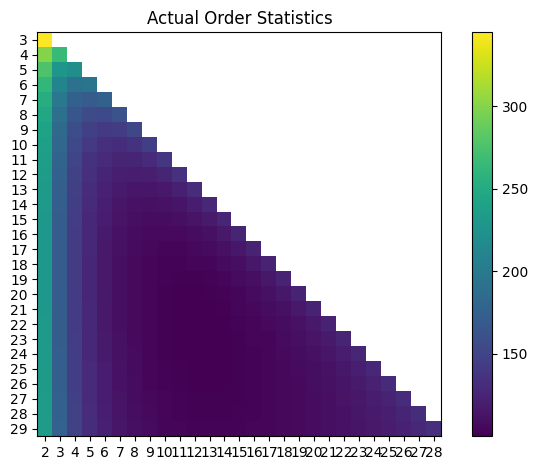

In [3]:
ns = [str(i) for i in range(3, 30)]
ks = [str(i) for i in range(2, 29)]
plt.yticks(np.arange(len(ns)), labels=ns)
plt.xticks(np.arange(len(ks)), labels=ks)
plt.imshow(Es_kth_Ts_w_n)
cb = plt.colorbar()
plt.title('Actual Order Statistics')
# cb.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.show()

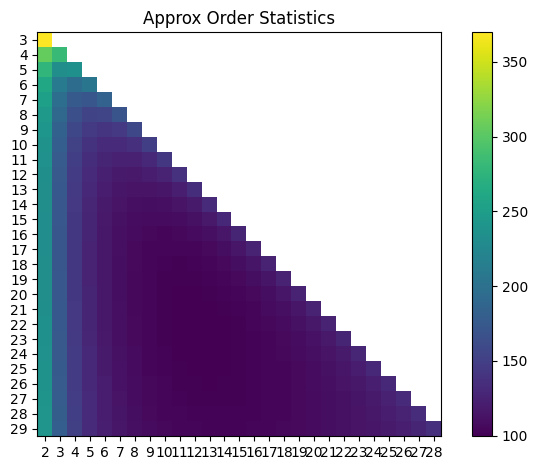

In [4]:
plt.yticks(np.arange(len(ns)), labels=ns)
plt.xticks(np.arange(len(ks)), labels=ks)
plt.imshow(approx_n)
cb = plt.colorbar()
plt.title('Approx Order Statistics')
# cb.ax.tick_params(labelsize=16)

plt.tight_layout()
plt.show()

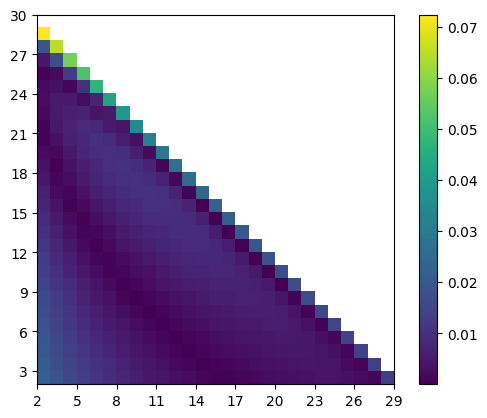

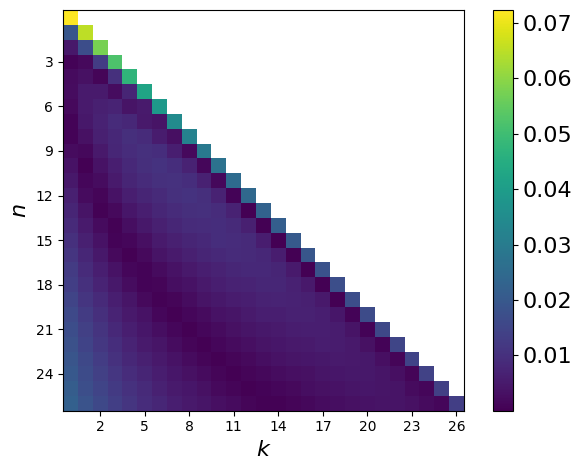

In [5]:
actual_approx_diff = np.abs(Es_kth_Ts_w_n - approx_n) / Es_kth_Ts_w_n
# plt.yticks(np.arange(len(ns)), labels=ns, size=12)
# plt.xticks(np.arange(len(ks)), labels=ks, size=12)
fig, ax = plt.subplots()
im = ax.imshow(actual_approx_diff, extent=[2, 2+len(actual_approx_diff), 2, 2+len(actual_approx_diff)])

# 设置横纵坐标的刻度位置和标签
ax.set_xticks(np.arange(2, 2+len(actual_approx_diff)+1, 3))
ax.set_xticklabels(np.arange(2, 2+len(actual_approx_diff)+1, 3))
# y_ticks = np.arange(3+len(actual_approx_diff), 2, -3)
y_ticks = np.arange(3, 3+len(actual_approx_diff)+1, 3)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks)
# 添加颜色条
plt.colorbar(im)

# 显示图形
plt.show()


# plt.yticks(list(range(3, 33, 3)), size=16)
# plt.xticks(list(range(2, 33, 3)), size=16)
plt.xticks(np.arange(2, 31, 3), np.arange(2, 31, 3))

# 设置纵坐标的刻度位置和标签
yticks = np.arange(30, 2, -3)  # 反向生成纵坐标的刻度位置
plt.yticks(yticks, yticks)

plt.ylabel('$n$', rotation=90, size=16)
plt.xlabel('$k$', size=16)
plt.imshow(actual_approx_diff)
cb = plt.colorbar()
# plt.title('Diff between Actual and Approx')
cb.ax.tick_params(labelsize=16)
plt.tight_layout()
# plt.savefig('order_statistic_approx_nk.pdf')
plt.show()

# fig, ax = plt.subplots()
# data = np.random.rand(5, 5)
# # 画热力图
# im = ax.imshow(data, extent=[2, 2+len(data), 2, 2+len(data)])

# # 设置横纵坐标的刻度位置和标签
# ax.set_xticks(np.arange(2, 2+len(data)+1, 3))
# ax.set_yticks(np.arange(2, 2+len(data)+1, 3))

# # 设置刻度标签显示的内容
# ax.set_xticklabels(np.arange(2, 2+len(data)+1, 3))
# ax.set_yticklabels(np.arange(2, 2+len(data)+1, 3))

# # 添加颜色条
# plt.colorbar(im)

# # 显示图形
# plt.show()